In [1]:
import pandas as pd

In [44]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
all_series = {
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "International airline passengers: monthly totals in thousands": airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'],
}

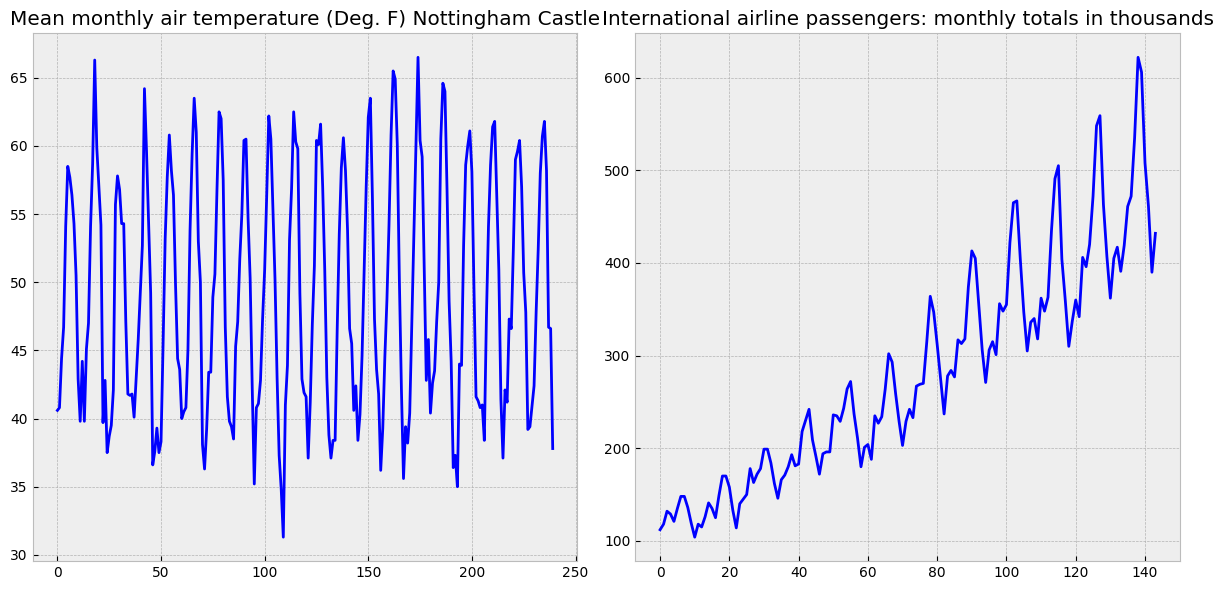

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 6))
    layout = (1, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

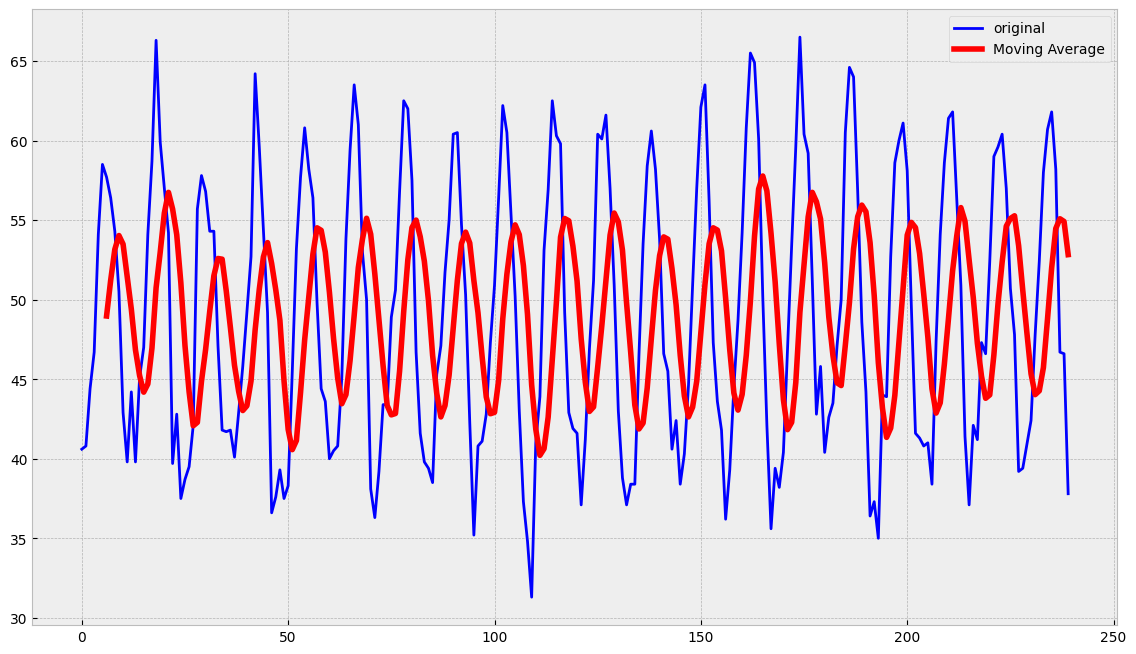

In [7]:
mean_monthly = moving_average(mean_monthly_temp["Deg"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp['Deg'], color='blue',label='original')
    plt.plot(mean_monthly, color='red', linewidth='4', label='Moving Average')
    plt.legend()

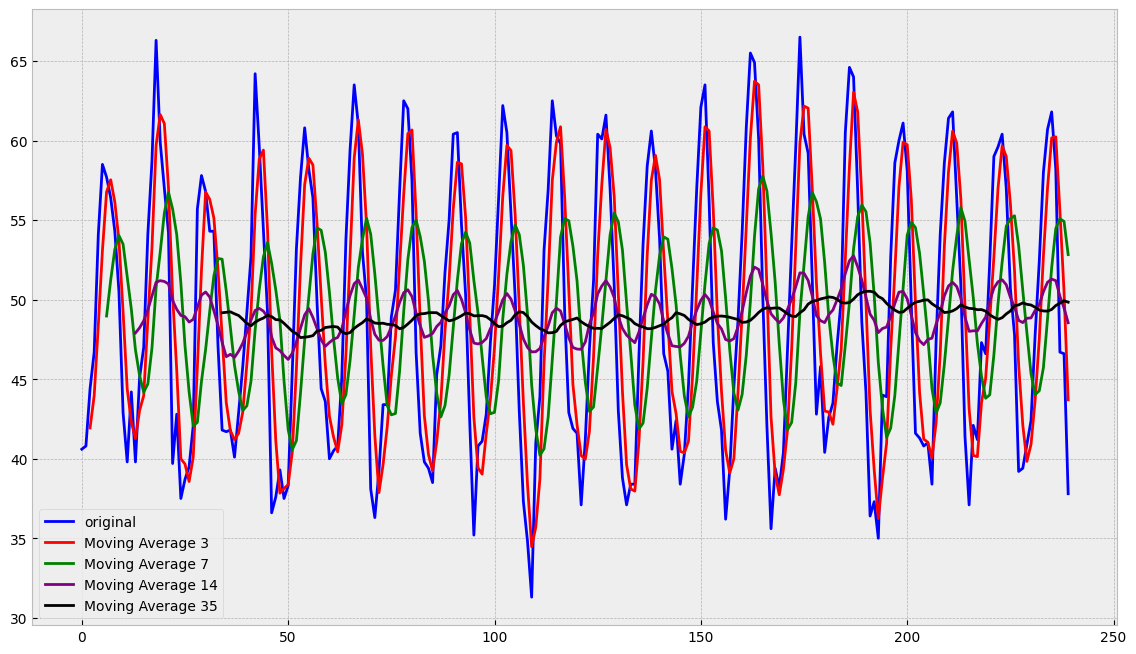

In [8]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp['Deg'], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(mean_monthly_temp['Deg'], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

На данной модели видна горизонтальная линия тренда

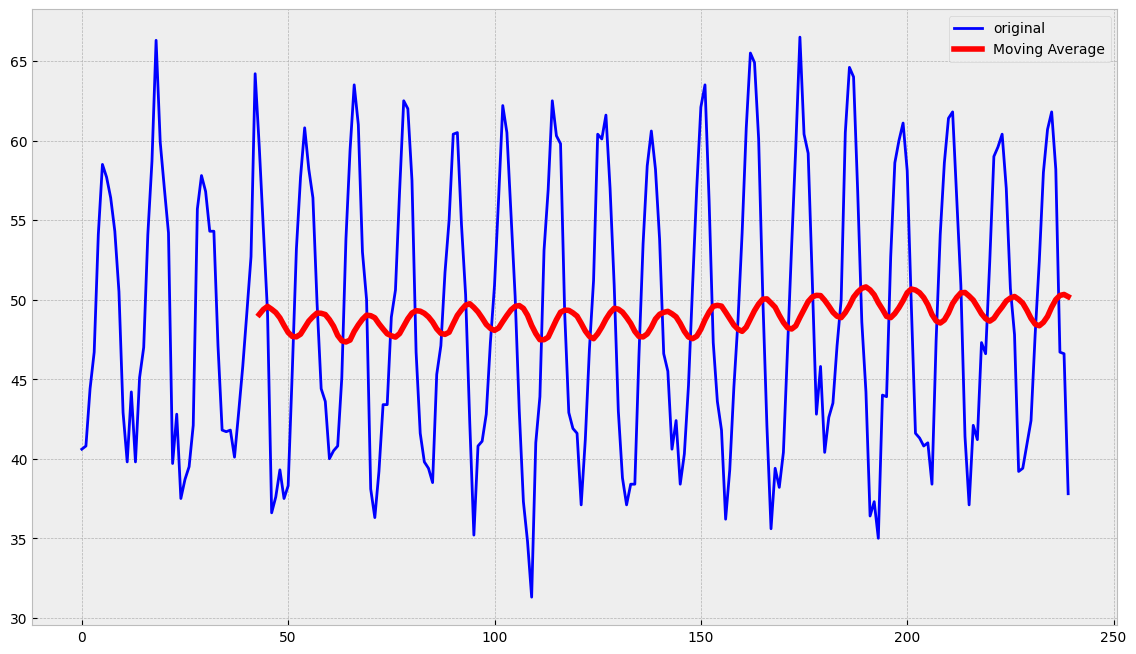

In [9]:
ts = mean_monthly_temp['Deg']
ser = moving_average(ts, 44)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [14]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [15]:
def plot_dema(alpha, beta):
    dema = double_ema(mean_monthly_temp['Deg'], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(mean_monthly_temp['Deg'], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

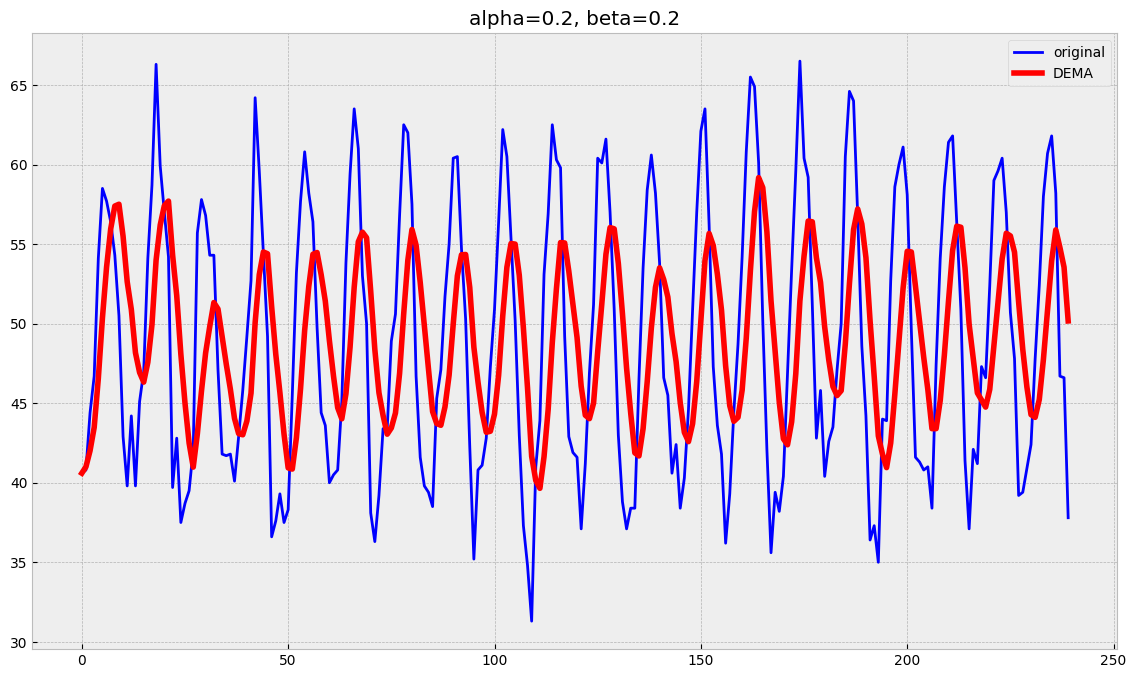

In [16]:
plot_dema(0.2, 0.2)

In [19]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [20]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [21]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [22]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp['Deg'], ser_to_plot=mean_monthly_temp['Deg'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

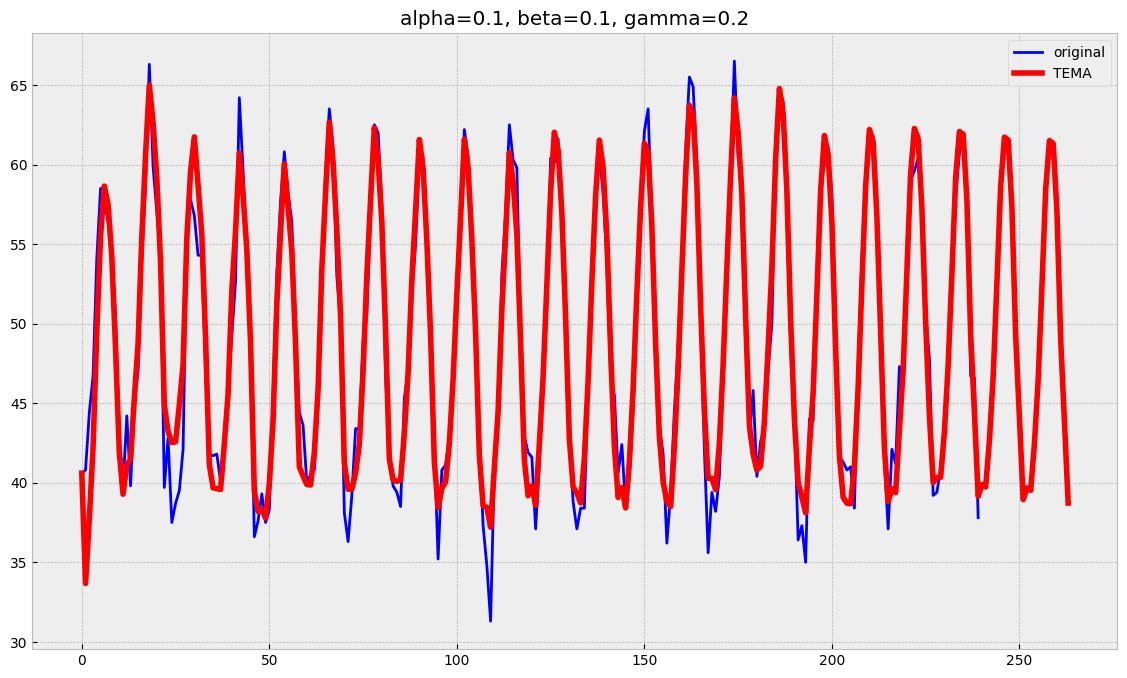

In [23]:
plot_tema(0.1, 0.1, 0.2)

In [33]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [34]:
series = mean_monthly_temp['Deg']

In [35]:
train, test, val = series[:60], series[60:70], series[70:]

In [36]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [37]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [38]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 6.888572100694451
        x: [ 1.000e+00  0.000e+00  1.000e+00]
      nit: 1
      jac: [-3.862e+00  2.184e+02 -0.000e+00]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


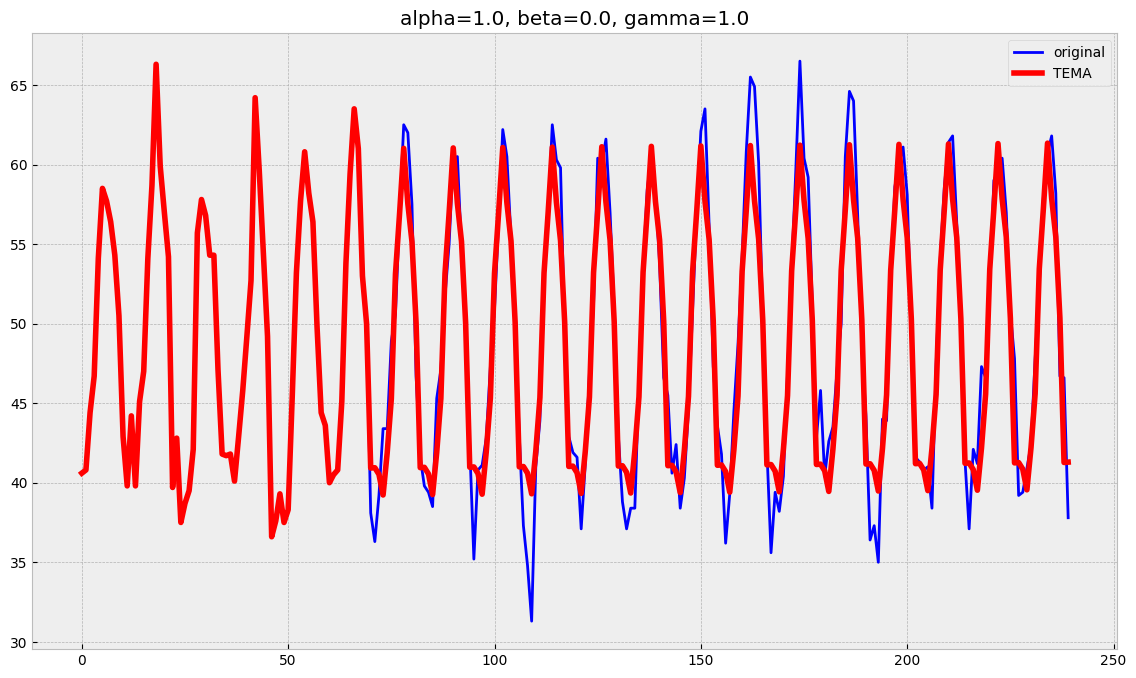

In [39]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

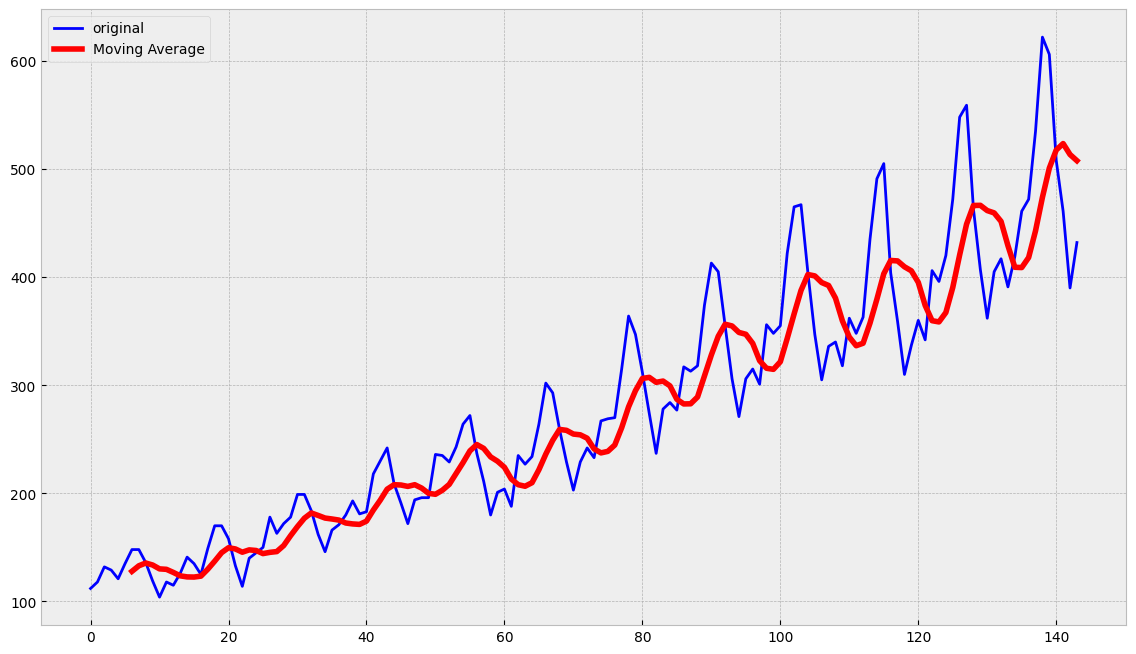

In [40]:
air_passengers = moving_average(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], color='blue',label='original')
    plt.plot(air_passengers, color='red', linewidth='4', label='Moving Average')
    plt.legend()

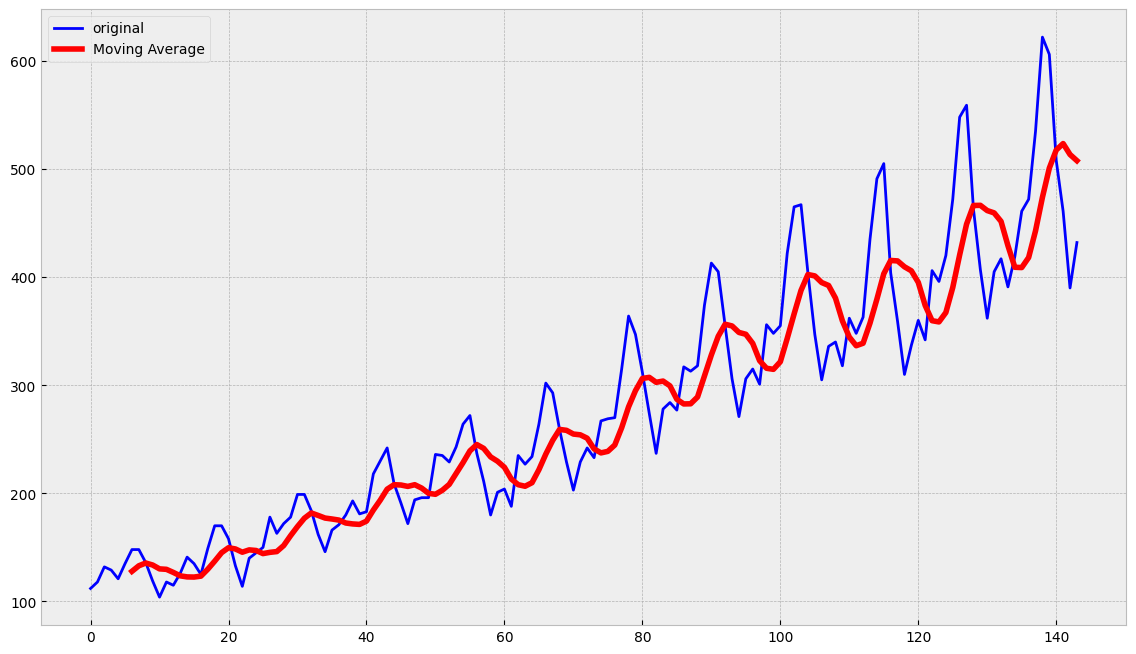

In [46]:
air_passengers = moving_average(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], color='blue',label='original')
    plt.plot(air_passengers, color='red', linewidth='4', label='Moving Average')
    plt.legend()

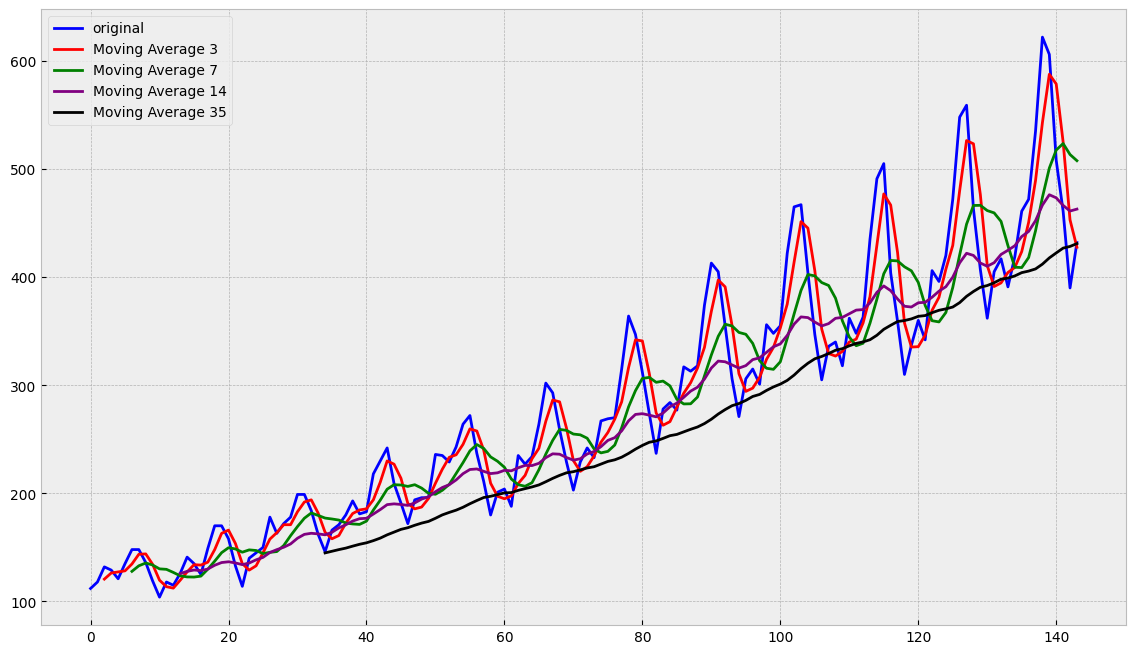

In [47]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

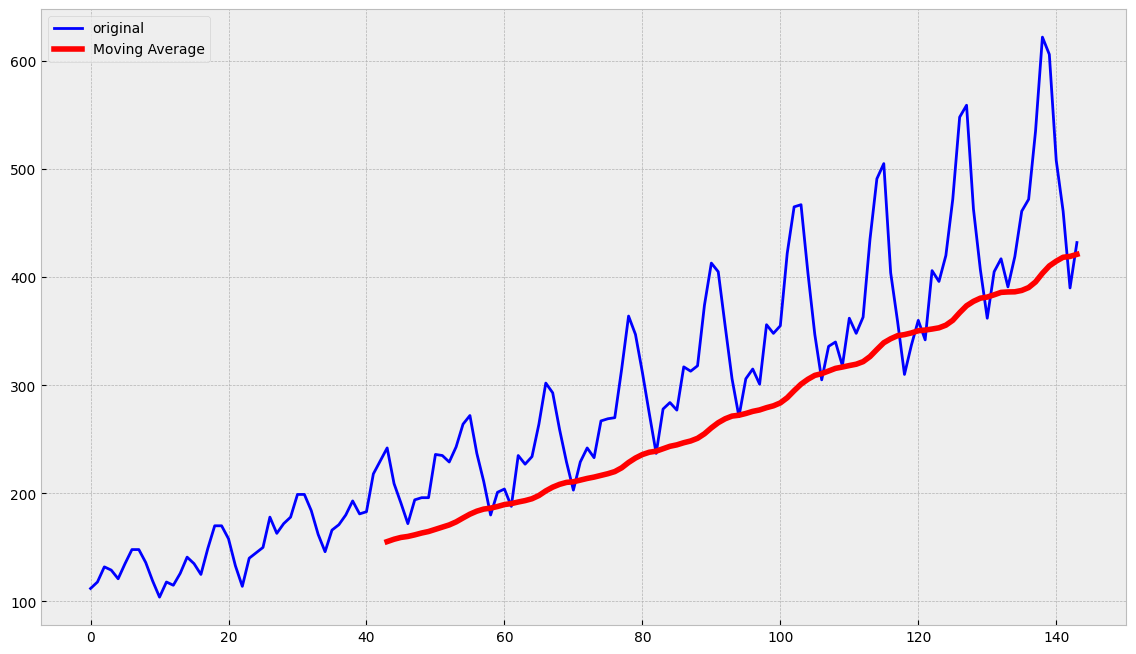

In [48]:
ts = airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']
ser = moving_average(ts, 44)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Возрастающая линия тренда

In [49]:
def plot_dema(alpha, beta):
    dema = double_ema(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

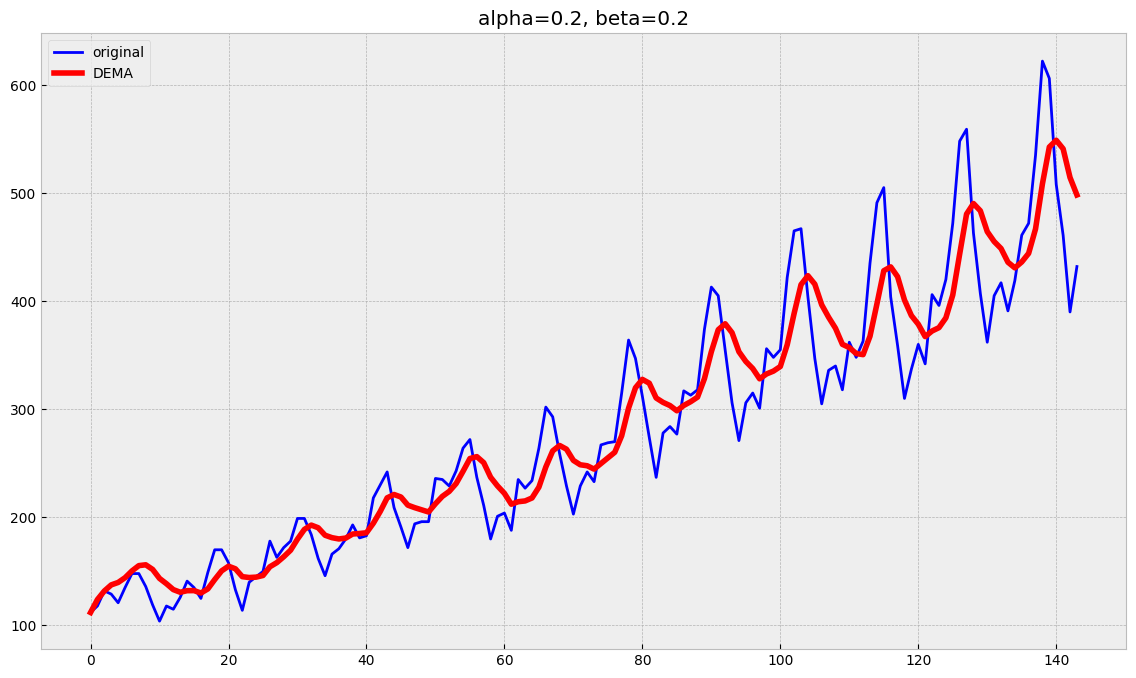

In [50]:
plot_dema(0.2, 0.2)

In [51]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], ser_to_plot=airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

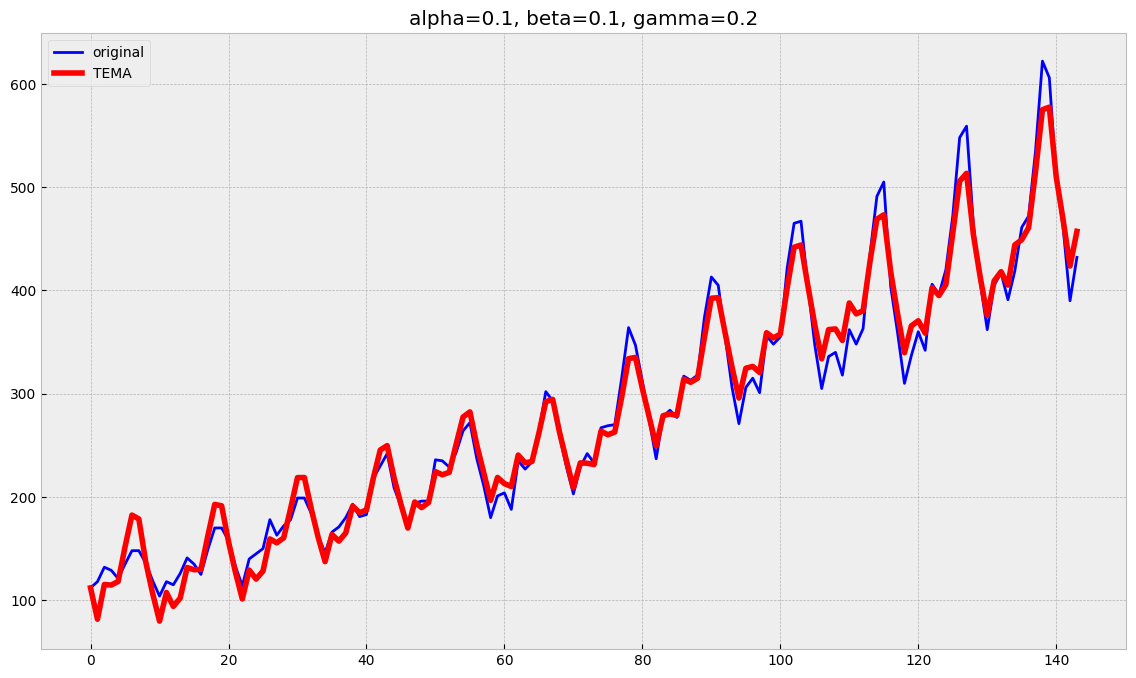

In [52]:
plot_tema(0.1, 0.1, 0.2)

In [53]:
series_2 = airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']

In [54]:
train, test, val = series_2[:60], series_2[60:70], series_2[70:]

In [55]:
opt_2 = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [56]:
alpha_opt, beta_opt, gamma_opt = opt_2.x
print(opt_2)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 175.55253454606682
        x: [ 2.678e-03  8.758e-01  0.000e+00]
      nit: 136
      jac: [ 1.514e+01  3.072e-02  1.057e+01]
     nfev: 856
     njev: 214
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


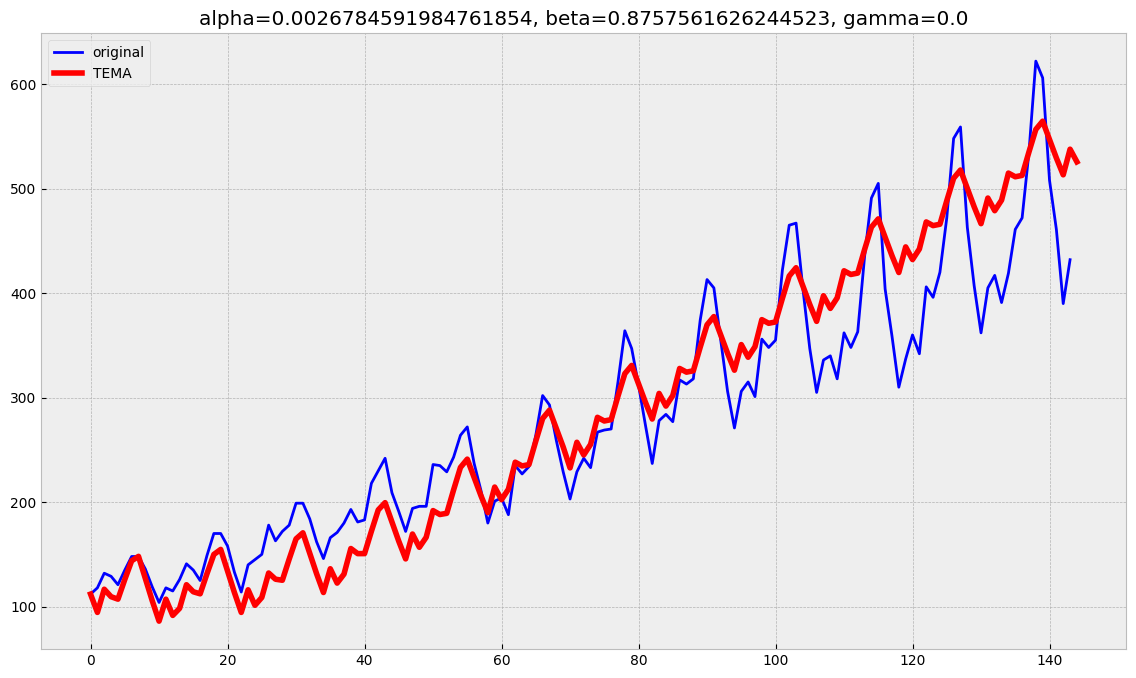

In [58]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series_2[:70], ser_to_plot=series_2, n_preds=len(val))

mean-monthly-air-temperature-deg При высоком n среднего сглаживания. Более точно видна линия тренда. Горизонтальная линия.
international-airline-passengers Здесь любая модель подойдет. Очень четкая линия тренда.